In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import glob
import json
import time

import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import torch
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.inferers import sliding_window_inference
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.networks.nets import SwinUNETR
from monai.transforms import (AsDiscrete, Compose, CropForegroundd,
                              EnsureChannelFirstd, LoadImaged, Orientationd,
                              RandAffined, RandCropByPosNegLabeld,
                              ResizeWithPadOrCropd, ScaleIntensityRanged,
                              Spacingd, AddChanneld)
from monai.utils import first, set_determinism
from torch import nn
from tqdm import tqdm

In [2]:
set_determinism(seed=0)

TASK_ID = "01"
DATA_DIR = "/scratch/MSD"
MODEL_DIR = "/scratch/MSD/logs/pre_train/swin/runs/"
LOG_DIR = "/scratch/MSD/logs/fine_tune/"
DEVICE_IDS = [0, 1]

SSL = True
SSL_PATH = os.path.normpath(MODEL_DIR + "model_bestValRMSE.pt")
TRAIN_SIZE = 0.8

ROI = (96, 96, 96)
VAL_ROI = (160, 160, 160)
TBS = 1
VBS = 1
SWBS = 4
N_W = 4

INFER_OVERLAP = 0.5
MAX_EPOCHS = 600
VAL_INTERVAL = 10

task_name = {
    "01": "Task01_BrainTumour",
    "02": "Task02_Heart",
    "03": "Task03_Liver",
    "04": "Task04_Hippocampus",
    "05": "Task05_Prostate",
    "06": "Task06_Lung",
    "07": "Task07_Pancreas",
    "08": "Task08_HepaticVessel",
    "09": "Task09_Spleen",
    "10": "Task10_Colon",
}

img_min_max = [[0.0, 11737.0], [], [], [], [], [], [], [], [], [-1024.0, 13438.0]]

In [3]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = np.where(self.count > 0, self.sum / self.count, self.sum)

def datafold_read(datalist, basedir, fold=0, key="training"):
    with open(datalist) as f:
        json_data = json.load(f)

    json_data = json_data[key]

    for d in json_data:
        for k in d:
            if isinstance(d[k], list):
                d[k] = [os.path.join(basedir, iv) for iv in d[k]]
            elif isinstance(d[k], str):
                d[k] = os.path.join(basedir, d[k]) if len(d[k]) > 0 else d[k]

    tr = []
    val = []
    for d in json_data:
        if "fold" in d and d["fold"] == fold:
            val.append(d)
        else:
            tr.append(d)

    return tr, val

def check_image_range(images):
    minn, maxx = np.inf, -np.inf
    for i in tqdm(range(len(images))):
        img = nib.load(images[i])
        data = img.get_fdata()
        minn = min(minn, data.min())
        maxx = max(maxx, data.max())
        del img
    return minn, maxx

def save_checkpoint(model, epoch, filename="model.pt", best_acc=0):
    state_dict = model.state_dict()
    save_dict = {"epoch": epoch, "best_acc": best_acc, "state_dict": state_dict}
    filename = os.path.join(LOG_DIR, filename)
    torch.save(save_dict, filename)
    print("Saving checkpoint", filename)

In [4]:
def get_loader(cache=True):
    data_dir = os.path.join(DATA_DIR, task_name[TASK_ID])
    train_images = sorted(
        glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
    train_labels = sorted(
        glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
    data_dicts = [
        {"image": image_name, "label": label_name}
        for image_name, label_name in zip(train_images, train_labels)
    ]

    indexes = np.arange(len(data_dicts))
    np.random.shuffle(indexes)
    split = int(len(data_dicts) * TRAIN_SIZE)
    train_indexes, val_indexes = indexes[:split], indexes[split:]
    train_files = [data_dicts[i] for i in train_indexes]
    val_files = [data_dicts[i] for i in val_indexes]
    print("Training files:", len(train_files), "Validation files:", len(val_files))

    a_min, a_max = img_min_max[int(TASK_ID) - 1]
    b_min, b_max = 0.0, 1.0

    train_transforms = Compose(
        [
            LoadImaged(keys=["image", "label"]),
            EnsureChannelFirstd(keys=["image", "label"]),
            Spacingd(keys=["image", "label"], pixdim=(
                1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
            ScaleIntensityRanged(
                keys=["image"], a_min=a_min, a_max=a_max,
                b_min=b_min, b_max=b_max, clip=True,
            ),
            CropForegroundd(keys=["image", "label"], source_key="image"),
            RandCropByPosNegLabeld(
                keys=["image", "label"],
                label_key="label",
                spatial_size=(ROI[0], ROI[1], ROI[2]),
                pos=1,
                neg=1,
                num_samples=4,
                image_key="image",
                image_threshold=0,
                allow_smaller=True
            ),
            ResizeWithPadOrCropd(keys=["image", "label"],
                spatial_size=(ROI[0], ROI[1], ROI[2]),
                mode='constant'),
            RandAffined(
                keys=['image', 'label'],
                mode=('bilinear', 'nearest'),
                prob=1.0, spatial_size=(ROI[0], ROI[1], ROI[2]),
                rotate_range=(0, 0, np.pi/15),
                scale_range=(0.1, 0.1, 0.1)),
        ]
    )
    val_transforms = Compose(
        [
            LoadImaged(keys=["image", "label"]),
            EnsureChannelFirstd(keys=["image", "label"]),
            Spacingd(keys=["image", "label"], pixdim=(
                1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
            ScaleIntensityRanged(
                keys=["image"], a_min=a_min, a_max=a_max,
                b_min=b_min, b_max=b_max, clip=True,
            ),
            CropForegroundd(keys=["image", "label"], source_key="image"),
        ]
    )

    if cache:
        train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0)
        val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0)
    else:
        train_ds = Dataset(data=train_files, transform=train_transforms)
        val_ds = Dataset(data=val_files, transform=val_transforms)
    train_loader = DataLoader(train_ds, batch_size=TBS, num_workers=N_W, shuffle=True, drop_last=False)
    val_loader = DataLoader(val_ds, batch_size=VBS, num_workers=N_W, shuffle=False, drop_last=False)
    return train_loader, val_loader

train_loader, val_loader = get_loader(cache=False)

Training files: 387 Validation files: 97


monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.


In [19]:
check_data = first(train_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
image.shape, label.shape

(torch.Size([96, 96, 96]), torch.Size([96, 96, 96]))

image shape: torch.Size([90, 115, 70]), label shape: torch.Size([90, 115, 70])


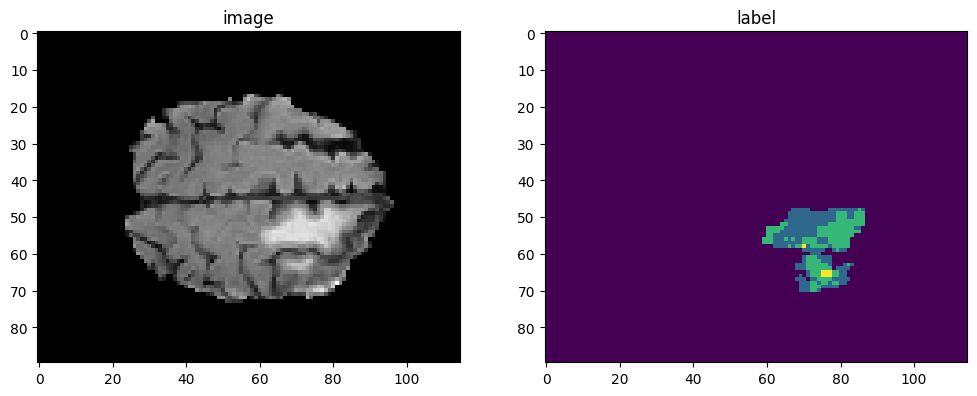

In [15]:
check_data = first(val_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
idx = np.random.randint(0, image.shape[2])
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, idx], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, idx])
plt.show()

In [5]:
device = torch.device(f"cuda" if torch.cuda.is_available() else "cpu")

from monai.networks.blocks import PatchEmbed, UnetrBasicBlock

model = SwinUNETR(
    img_size=ROI,
    in_channels=1,
    out_channels=2,
    feature_size=48,
    drop_rate=0.0,
    attn_drop_rate=0.0,
    dropout_path_rate=0.0,
    norm_name="batch",
)

if SSL is True:
    print("Loading Weights from the Path {}".format(SSL_PATH))
    weights = torch.load(SSL_PATH)
    old_sd = weights["state_dict"].keys()
    new_sd = {}
    for k in old_sd:
        new_sd[k.replace("swinViT.", "")] = weights["state_dict"][k]

    model.swinViT.load_state_dict(new_sd, strict=False)
    model.swinViT.patch_embed = PatchEmbed(
                patch_size=model.swinViT.patch_size,
                in_chans=4,
                embed_dim=48,
                norm_layer=nn.LayerNorm,
                spatial_dims=3
    )
    model.encoder1 = UnetrBasicBlock(
            spatial_dims=3,
            in_channels=4,
            out_channels=48,
            kernel_size=3,
            stride=1,
            norm_name="instance",
            res_block=True,
    )
    del weights, new_sd, old_sd
    print("Pretrained Weights Succesfully Loaded !")

model = nn.DataParallel(model, device_ids = DEVICE_IDS)
model.to(device)

torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = False
dice_loss = DiceLoss(to_onehot_y=False, softmax=True)
dice_metric = DiceMetric(include_background=False, reduction="mean") 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=MAX_EPOCHS)

Loading Weights from the Path /scratch/MSD/logs/pre_train/swin/runs/model_bestValRMSE.pt
Pretrained Weights Succesfully Loaded !


In [6]:
def train_epoch(model, loader, optimizer, epoch, loss_func):
    model.train()
    run_loss = AverageMeter()
    for idx, batch_data in enumerate(loader):
        data, target = (
            batch_data["image"].to(device), 
            batch_data["label"].to(device)
        )
        optimizer.zero_grad()
        logits = model(data)
        loss = loss_func(logits, target)
        loss.backward()
        optimizer.step()
        run_loss.update(loss.item(), n=TBS)
        del data, target, logits
    return run_loss.avg

def val_epoch(model, loader, post_label, post_pred, acc_func):
    model.eval()
    with torch.no_grad():
        for idx, val_data in enumerate(loader):
            val_inputs, val_labels = (
                val_data["image"].to(device),
                val_data["label"].to(device),
            )
            val_outputs = sliding_window_inference(
                val_inputs, VAL_ROI, SWBS, model, INFER_OVERLAP)
            val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
            val_labels = [post_label(i) for i in decollate_batch(val_labels)]
            # compute metric for current iteration
            acc_func(y_pred=val_outputs, y=val_labels)
            del val_inputs, val_labels, val_outputs

        metric = dice_metric.aggregate().item()
        dice_metric.reset()
    return metric

In [7]:
def trainer(model, train_loader, val_loader, optimizer, loss_func, acc_func, scheduler):
    val_acc_max = 0.0
    dices_avg = []
    loss_epochs = []
    trains_epoch = []
    post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
    post_label = Compose([AsDiscrete(to_onehot=2)])

    print(time.ctime(), "Starting Training")
    for epoch in range(MAX_EPOCHS):
        epoch_time = time.time()
        train_loss = train_epoch(model, train_loader, optimizer, epoch, loss_func)
        print(
            "E {}/{}".format(epoch, MAX_EPOCHS - 1),
            "Loss: {:.4f}".format(train_loss),
            "Time: {:.2f}s".format(time.time() - epoch_time),
        )

        if (epoch + 1) % VAL_INTERVAL == 0 or epoch == 0:
            loss_epochs.append(train_loss)
            trains_epoch.append(int(epoch))
            epoch_time = time.time()
            val_acc = val_epoch(model, val_loader, post_label, post_pred, acc_func)
            print(
                "V {}/{}".format(epoch, MAX_EPOCHS - 1),
                "Dice: {:.4f}".format(val_acc),
                "Time: {:.2f}s".format(time.time() - epoch_time),
            )
            dices_avg.append(val_acc)
            if val_acc > val_acc_max:
                print("New best: ({:.6f} --> {:.6f}) ".format(val_acc_max, val_acc))
                val_acc_max = val_acc
                save_checkpoint(model, epoch, filename="msd_ft_best.pt", best_acc=val_acc_max)
                
        scheduler.step()
    print("Training Finished !, Best Accuracy: ", val_acc_max, time.ctime())
    return val_acc_max, dices_avg, loss_epochs, trains_epoch

In [ ]:
val_acc_max, dices_avg, loss_epochs, trains_epoch = trainer(model, train_loader, val_loader, optimizer, dice_loss, dice_metric, scheduler)

In [ ]:
save_checkpoint(model, 1000, filename="msd_full.pt", best_acc=val_acc_max)